In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import re
%matplotlib inline 

In [2]:
model_name = "Weight_lep_pt"

In [3]:
# Throw away lepton mass 

# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  1000000

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            if key == 'tl_phi' or key == 'wl_phi':
                z = phi1_transform(var, max0, mean, exist) 
            else:
                z = phi2_transform(var, max0, mean, exist)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return arrays

def invscale_arrays(keys, arrays, maxmean_dict):
    exist_dict = jet_existence_dict()

    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        full_key = keys[i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            exist = exist_dict[full_key]
            if full_key == 'tl_phi' or full_key == 'wl_phi':
                total.append(invphi1_transform(z, max0, mean, exist))
            else:
                total.append(invphi2_transform(z, max0, mean, exist))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

In [7]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input = scale_arrays(input_keys, maxmean)

total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)

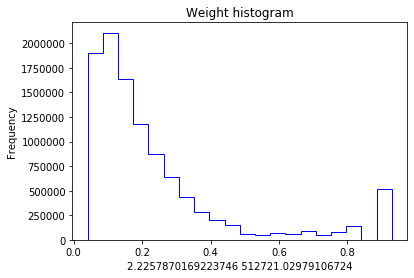

(1000000,)


In [35]:
# Reweight

def get_reweight1():
    key = 'lep_pt'
    i = input_keys.index(key)
    base = total_input[:,i]
    weight = (1 + base)**20
    return base, weight 
    
    
def get_reweight2():
    var = dataset.get('lep_pt')[0:crop0]
    max0 = np.max(var)
    bin_edges = np.linspace(0, max0, num=30, endpoint=True)
    bin_edges[-1] = np.inf
    hist0, _ = np.histogram(var,bin_edges, density=False)
    hist1 = (hist0==0)*1 + hist0
    

    pt_bin = np.digitize(var, bin_edges)-1
    weights = 1/hist1
    zweights = weights/np.min(weights)

    tr_weights = weights[pt_bin]
    return var, tr_weights, bin_edges
    
    
lep_pt, weight = get_reweight1()
plt.hist(lep_pt, 20, histtype='step', color='b', weights=weight)

# lep_pt, weight, edges = get_reweight2()
# plt.hist(lep_pt, edges, histtype='step', color='b', weights= weight)

plt.title('Weight histogram')
plt.xlabel('{0} {1}'.format(np.min(weight), np.max(weight)))
plt.ylabel("Frequency")
plt.show()

print(weight.shape)

In [36]:
# Test inverse scaling
show = False

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(len(output_keys)):
        plt.subplot(output_length, 1, i+1)
        plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
        plt.xlabel(output_keys[i] + " scaling error")
        plt.ylabel('Frequency')

In [37]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]
weight = weight[0:split]

In [38]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)
print(weight.shape)

(800000, 36) (800000, 9)
(200000, 36) (200000, 9)
(800000,)


In [39]:
# Histograms of output variables 
show = False

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length, 1, i+1)
        plt.hist(train_output[:,i], 20, histtype='step')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')

In [40]:
# Histograms of input variables 
show = False

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [41]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_mse', patience=4)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [42]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               18944     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 128)              

In [43]:
# Fit model

Epochs= 2048

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512, sample_weight = weight)


Epoch 1/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 1.6319 - mse: 0.1613 - val_loss: 1.3170 - val_mse: 0.1403
Epoch 2/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 1.1550 - mse: 0.1165 - val_loss: 0.8278 - val_mse: 0.0938
Epoch 3/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.7084 - mse: 0.0778 - val_loss: 0.5167 - val_mse: 0.0670
Epoch 4/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.5008 - mse: 0.0619 - val_loss: 0.4061 - val_mse: 0.0581
Epoch 5/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.4200 - mse: 0.0559 - val_loss: 0.3551 - val_mse: 0.0538
Epoch 6/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.3814 - mse: 0.0529 - val_loss: 0.3328 - val_mse: 0.0520
Epoch 7/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.3643 - mse: 0.0518 - val_loss: 0.3228 - val_mse: 0.0512
Epoch 8/2048
1250/1250 [==========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1721 - mse: 0.0333 - val_loss: 0.1704 - val_mse: 0.0331
Epoch 61/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1715 - mse: 0.0332 - val_loss: 0.1699 - val_mse: 0.0331
Epoch 62/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1710 - mse: 0.0331 - val_loss: 0.1694 - val_mse: 0.0330
Epoch 63/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1705 - mse: 0.0330 - val_loss: 0.1690 - val_mse: 0.0329
Epoch 64/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1700 - mse: 0.0330 - val_loss: 0.1685 - val_mse: 0.0328
Epoch 65/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1695 - mse: 0.0329 - val_loss: 0.1682 - val_mse: 0.0328
Epoch 66/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1691 - mse: 0.0328 - val_loss: 0.1678 - val_mse: 0.0327
Epoch 67/2048
1250/1250 [================

Epoch 119/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1570 - mse: 0.0309 - val_loss: 0.1572 - val_mse: 0.0308
Epoch 120/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1569 - mse: 0.0309 - val_loss: 0.1571 - val_mse: 0.0308
Epoch 121/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1567 - mse: 0.0308 - val_loss: 0.1569 - val_mse: 0.0308
Epoch 122/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1566 - mse: 0.0308 - val_loss: 0.1568 - val_mse: 0.0308
Epoch 123/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1565 - mse: 0.0308 - val_loss: 0.1567 - val_mse: 0.0307
Epoch 124/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1563 - mse: 0.0308 - val_loss: 0.1566 - val_mse: 0.0307
Epoch 125/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1562 - mse: 0.0307 - val_loss: 0.1564 - val_mse: 0.0307
Epoch 126/2048
1250/

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1507 - mse: 0.0299 - val_loss: 0.1515 - val_mse: 0.0299
Epoch 178/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1506 - mse: 0.0299 - val_loss: 0.1514 - val_mse: 0.0298
Epoch 179/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1505 - mse: 0.0299 - val_loss: 0.1513 - val_mse: 0.0298
Epoch 180/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1504 - mse: 0.0299 - val_loss: 0.1512 - val_mse: 0.0298
Epoch 181/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1503 - mse: 0.0298 - val_loss: 0.1511 - val_mse: 0.0298
Epoch 182/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1502 - mse: 0.0298 - val_loss: 0.1511 - val_mse: 0.0298
Epoch 183/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1502 - mse: 0.0298 - val_loss: 0.1510 - val_mse: 0.0298
Epoch 184/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1465 - mse: 0.0292 - val_loss: 0.1477 - val_mse: 0.0292
Epoch 236/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1464 - mse: 0.0292 - val_loss: 0.1477 - val_mse: 0.0292
Epoch 237/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1464 - mse: 0.0292 - val_loss: 0.1476 - val_mse: 0.0292
Epoch 238/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1463 - mse: 0.0292 - val_loss: 0.1476 - val_mse: 0.0292
Epoch 239/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1462 - mse: 0.0292 - val_loss: 0.1475 - val_mse: 0.0292
Epoch 240/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1462 - mse: 0.0292 - val_loss: 0.1475 - val_mse: 0.0292
Epoch 241/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1461 - mse: 0.0292 - val_loss: 0.1474 - val_mse: 0.0292
Epoch 242/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1433 - mse: 0.0287 - val_loss: 0.1449 - val_mse: 0.0287
Epoch 294/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1432 - mse: 0.0287 - val_loss: 0.1448 - val_mse: 0.0287
Epoch 295/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1432 - mse: 0.0287 - val_loss: 0.1448 - val_mse: 0.0287
Epoch 296/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1431 - mse: 0.0287 - val_loss: 0.1448 - val_mse: 0.0287
Epoch 297/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1431 - mse: 0.0287 - val_loss: 0.1447 - val_mse: 0.0287
Epoch 298/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1430 - mse: 0.0287 - val_loss: 0.1447 - val_mse: 0.0287
Epoch 299/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1430 - mse: 0.0287 - val_loss: 0.1446 - val_mse: 0.0287
Epoch 300/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1406 - mse: 0.0283 - val_loss: 0.1426 - val_mse: 0.0283
Epoch 352/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1406 - mse: 0.0283 - val_loss: 0.1425 - val_mse: 0.0283
Epoch 353/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1406 - mse: 0.0283 - val_loss: 0.1425 - val_mse: 0.0283
Epoch 354/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1405 - mse: 0.0283 - val_loss: 0.1424 - val_mse: 0.0283
Epoch 355/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1405 - mse: 0.0283 - val_loss: 0.1424 - val_mse: 0.0283
Epoch 356/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1404 - mse: 0.0283 - val_loss: 0.1424 - val_mse: 0.0283
Epoch 357/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1404 - mse: 0.0283 - val_loss: 0.1423 - val_mse: 0.0283
Epoch 358/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1384 - mse: 0.0279 - val_loss: 0.1406 - val_mse: 0.0280
Epoch 410/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1383 - mse: 0.0279 - val_loss: 0.1406 - val_mse: 0.0279
Epoch 411/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1383 - mse: 0.0279 - val_loss: 0.1405 - val_mse: 0.0279
Epoch 412/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1383 - mse: 0.0279 - val_loss: 0.1405 - val_mse: 0.0279
Epoch 413/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1382 - mse: 0.0279 - val_loss: 0.1405 - val_mse: 0.0279
Epoch 414/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1382 - mse: 0.0279 - val_loss: 0.1404 - val_mse: 0.0279
Epoch 415/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1382 - mse: 0.0279 - val_loss: 0.1404 - val_mse: 0.0279
Epoch 416/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1363 - mse: 0.0276 - val_loss: 0.1389 - val_mse: 0.0276
Epoch 468/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1363 - mse: 0.0276 - val_loss: 0.1388 - val_mse: 0.0276
Epoch 469/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1362 - mse: 0.0276 - val_loss: 0.1388 - val_mse: 0.0276
Epoch 470/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1362 - mse: 0.0276 - val_loss: 0.1388 - val_mse: 0.0276
Epoch 471/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1362 - mse: 0.0276 - val_loss: 0.1387 - val_mse: 0.0276
Epoch 472/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1361 - mse: 0.0275 - val_loss: 0.1387 - val_mse: 0.0276
Epoch 473/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1361 - mse: 0.0275 - val_loss: 0.1387 - val_mse: 0.0276
Epoch 474/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1343 - mse: 0.0272 - val_loss: 0.1373 - val_mse: 0.0273
Epoch 526/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1343 - mse: 0.0272 - val_loss: 0.1372 - val_mse: 0.0273
Epoch 527/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1343 - mse: 0.0272 - val_loss: 0.1372 - val_mse: 0.0273
Epoch 528/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1342 - mse: 0.0272 - val_loss: 0.1372 - val_mse: 0.0273
Epoch 529/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1342 - mse: 0.0272 - val_loss: 0.1371 - val_mse: 0.0273
Epoch 530/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1342 - mse: 0.0272 - val_loss: 0.1371 - val_mse: 0.0273
Epoch 531/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1341 - mse: 0.0272 - val_loss: 0.1371 - val_mse: 0.0273
Epoch 532/2048
1250/1250 [=========

1250/1250 [==============================] - 14s 11ms/step - loss: 0.1326 - mse: 0.0269 - val_loss: 0.1359 - val_mse: 0.0270
Epoch 584/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1326 - mse: 0.0269 - val_loss: 0.1358 - val_mse: 0.0270
Epoch 585/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1325 - mse: 0.0269 - val_loss: 0.1358 - val_mse: 0.0270
Epoch 586/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1325 - mse: 0.0269 - val_loss: 0.1358 - val_mse: 0.0270
Epoch 587/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1325 - mse: 0.0269 - val_loss: 0.1358 - val_mse: 0.0270
Epoch 588/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1324 - mse: 0.0269 - val_loss: 0.1357 - val_mse: 0.0270
Epoch 589/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1324 - mse: 0.0269 - val_loss: 0.1357 - val_mse: 0.0270
Epoch 590/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1311 - mse: 0.0267 - val_loss: 0.1347 - val_mse: 0.0268
Epoch 642/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1311 - mse: 0.0267 - val_loss: 0.1347 - val_mse: 0.0268
Epoch 643/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1310 - mse: 0.0267 - val_loss: 0.1347 - val_mse: 0.0268
Epoch 644/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1310 - mse: 0.0267 - val_loss: 0.1347 - val_mse: 0.0268
Epoch 645/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1310 - mse: 0.0267 - val_loss: 0.1347 - val_mse: 0.0268
Epoch 646/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1310 - mse: 0.0267 - val_loss: 0.1346 - val_mse: 0.0268
Epoch 647/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1309 - mse: 0.0267 - val_loss: 0.1346 - val_mse: 0.0268
Epoch 648/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1298 - mse: 0.0265 - val_loss: 0.1337 - val_mse: 0.0267
Epoch 700/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1298 - mse: 0.0265 - val_loss: 0.1337 - val_mse: 0.0267
Epoch 701/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1297 - mse: 0.0265 - val_loss: 0.1337 - val_mse: 0.0266
Epoch 702/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1297 - mse: 0.0265 - val_loss: 0.1337 - val_mse: 0.0266
Epoch 703/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1297 - mse: 0.0265 - val_loss: 0.1337 - val_mse: 0.0266
Epoch 704/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1297 - mse: 0.0265 - val_loss: 0.1337 - val_mse: 0.0266
Epoch 705/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1297 - mse: 0.0265 - val_loss: 0.1336 - val_mse: 0.0266
Epoch 706/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1286 - mse: 0.0263 - val_loss: 0.1329 - val_mse: 0.0265
Epoch 758/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1286 - mse: 0.0263 - val_loss: 0.1329 - val_mse: 0.0265
Epoch 759/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1286 - mse: 0.0263 - val_loss: 0.1328 - val_mse: 0.0265
Epoch 760/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1285 - mse: 0.0263 - val_loss: 0.1328 - val_mse: 0.0265
Epoch 761/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1285 - mse: 0.0263 - val_loss: 0.1328 - val_mse: 0.0265
Epoch 762/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1285 - mse: 0.0263 - val_loss: 0.1328 - val_mse: 0.0265
Epoch 763/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1285 - mse: 0.0263 - val_loss: 0.1328 - val_mse: 0.0265
Epoch 764/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1275 - mse: 0.0261 - val_loss: 0.1321 - val_mse: 0.0264
Epoch 816/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1275 - mse: 0.0261 - val_loss: 0.1321 - val_mse: 0.0264
Epoch 817/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1275 - mse: 0.0261 - val_loss: 0.1321 - val_mse: 0.0264
Epoch 818/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1275 - mse: 0.0261 - val_loss: 0.1321 - val_mse: 0.0264
Epoch 819/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1274 - mse: 0.0261 - val_loss: 0.1321 - val_mse: 0.0264
Epoch 820/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1274 - mse: 0.0261 - val_loss: 0.1321 - val_mse: 0.0264
Epoch 821/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1274 - mse: 0.0261 - val_loss: 0.1321 - val_mse: 0.0264
Epoch 822/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1265 - mse: 0.0260 - val_loss: 0.1315 - val_mse: 0.0263
Epoch 874/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1265 - mse: 0.0260 - val_loss: 0.1315 - val_mse: 0.0263
Epoch 875/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1265 - mse: 0.0260 - val_loss: 0.1315 - val_mse: 0.0263
Epoch 876/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1265 - mse: 0.0260 - val_loss: 0.1314 - val_mse: 0.0263
Epoch 877/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1265 - mse: 0.0260 - val_loss: 0.1314 - val_mse: 0.0263
Epoch 878/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1265 - mse: 0.0260 - val_loss: 0.1314 - val_mse: 0.0263
Epoch 879/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1264 - mse: 0.0260 - val_loss: 0.1314 - val_mse: 0.0263
Epoch 880/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1256 - mse: 0.0259 - val_loss: 0.1309 - val_mse: 0.0262
Epoch 932/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1256 - mse: 0.0259 - val_loss: 0.1309 - val_mse: 0.0262
Epoch 933/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1256 - mse: 0.0259 - val_loss: 0.1309 - val_mse: 0.0262
Epoch 934/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1256 - mse: 0.0259 - val_loss: 0.1309 - val_mse: 0.0262
Epoch 935/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1256 - mse: 0.0259 - val_loss: 0.1309 - val_mse: 0.0262
Epoch 936/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1255 - mse: 0.0259 - val_loss: 0.1309 - val_mse: 0.0262
Epoch 937/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1255 - mse: 0.0259 - val_loss: 0.1309 - val_mse: 0.0262
Epoch 938/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1248 - mse: 0.0258 - val_loss: 0.1304 - val_mse: 0.0261
Epoch 990/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1248 - mse: 0.0257 - val_loss: 0.1304 - val_mse: 0.0261
Epoch 991/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1247 - mse: 0.0257 - val_loss: 0.1304 - val_mse: 0.0261
Epoch 992/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1247 - mse: 0.0257 - val_loss: 0.1304 - val_mse: 0.0261
Epoch 993/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1247 - mse: 0.0257 - val_loss: 0.1304 - val_mse: 0.0261
Epoch 994/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1247 - mse: 0.0257 - val_loss: 0.1303 - val_mse: 0.0261
Epoch 995/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1247 - mse: 0.0257 - val_loss: 0.1303 - val_mse: 0.0261
Epoch 996/2048
1250/1250 [=========

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1240 - mse: 0.0256 - val_loss: 0.1299 - val_mse: 0.0260
Epoch 1048/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1240 - mse: 0.0256 - val_loss: 0.1299 - val_mse: 0.0260
Epoch 1049/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1239 - mse: 0.0256 - val_loss: 0.1299 - val_mse: 0.0260
Epoch 1050/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1239 - mse: 0.0256 - val_loss: 0.1299 - val_mse: 0.0260
Epoch 1051/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1239 - mse: 0.0256 - val_loss: 0.1299 - val_mse: 0.0260
Epoch 1052/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1239 - mse: 0.0256 - val_loss: 0.1299 - val_mse: 0.0260
Epoch 1053/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1239 - mse: 0.0256 - val_loss: 0.1299 - val_mse: 0.0260
Epoch 1054/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1232 - mse: 0.0255 - val_loss: 0.1294 - val_mse: 0.0259
Epoch 1106/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1232 - mse: 0.0255 - val_loss: 0.1294 - val_mse: 0.0259
Epoch 1107/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1232 - mse: 0.0255 - val_loss: 0.1294 - val_mse: 0.0259
Epoch 1108/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1232 - mse: 0.0255 - val_loss: 0.1294 - val_mse: 0.0259
Epoch 1109/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1232 - mse: 0.0255 - val_loss: 0.1294 - val_mse: 0.0259
Epoch 1110/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1231 - mse: 0.0255 - val_loss: 0.1294 - val_mse: 0.0259
Epoch 1111/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1231 - mse: 0.0255 - val_loss: 0.1294 - val_mse: 0.0259
Epoch 1112/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1225 - mse: 0.0254 - val_loss: 0.1290 - val_mse: 0.0258
Epoch 1164/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1225 - mse: 0.0254 - val_loss: 0.1290 - val_mse: 0.0258
Epoch 1165/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1225 - mse: 0.0254 - val_loss: 0.1290 - val_mse: 0.0258
Epoch 1166/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1225 - mse: 0.0254 - val_loss: 0.1290 - val_mse: 0.0258
Epoch 1167/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1224 - mse: 0.0254 - val_loss: 0.1290 - val_mse: 0.0258
Epoch 1168/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1224 - mse: 0.0254 - val_loss: 0.1290 - val_mse: 0.0258
Epoch 1169/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1224 - mse: 0.0254 - val_loss: 0.1289 - val_mse: 0.0258
Epoch 1170/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1218 - mse: 0.0253 - val_loss: 0.1286 - val_mse: 0.0258
Epoch 1222/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1218 - mse: 0.0253 - val_loss: 0.1286 - val_mse: 0.0258
Epoch 1223/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1218 - mse: 0.0253 - val_loss: 0.1286 - val_mse: 0.0258
Epoch 1224/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1218 - mse: 0.0253 - val_loss: 0.1286 - val_mse: 0.0258
Epoch 1225/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1218 - mse: 0.0253 - val_loss: 0.1286 - val_mse: 0.0258
Epoch 1226/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1218 - mse: 0.0253 - val_loss: 0.1286 - val_mse: 0.0258
Epoch 1227/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1217 - mse: 0.0253 - val_loss: 0.1286 - val_mse: 0.0258
Epoch 1228/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1212 - mse: 0.0252 - val_loss: 0.1283 - val_mse: 0.0257
Epoch 1280/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1212 - mse: 0.0252 - val_loss: 0.1283 - val_mse: 0.0257
Epoch 1281/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1212 - mse: 0.0252 - val_loss: 0.1283 - val_mse: 0.0257
Epoch 1282/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1211 - mse: 0.0252 - val_loss: 0.1283 - val_mse: 0.0257
Epoch 1283/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1211 - mse: 0.0252 - val_loss: 0.1282 - val_mse: 0.0257
Epoch 1284/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1211 - mse: 0.0252 - val_loss: 0.1282 - val_mse: 0.0257
Epoch 1285/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1211 - mse: 0.0252 - val_loss: 0.1282 - val_mse: 0.0257
Epoch 1286/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1206 - mse: 0.0252 - val_loss: 0.1280 - val_mse: 0.0257
Epoch 1338/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1205 - mse: 0.0252 - val_loss: 0.1279 - val_mse: 0.0257
Epoch 1339/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1205 - mse: 0.0252 - val_loss: 0.1279 - val_mse: 0.0257
Epoch 1340/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1205 - mse: 0.0252 - val_loss: 0.1279 - val_mse: 0.0257
Epoch 1341/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1205 - mse: 0.0252 - val_loss: 0.1279 - val_mse: 0.0257
Epoch 1342/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1205 - mse: 0.0251 - val_loss: 0.1279 - val_mse: 0.0257
Epoch 1343/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1205 - mse: 0.0251 - val_loss: 0.1279 - val_mse: 0.0257
Epoch 1344/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1200 - mse: 0.0251 - val_loss: 0.1277 - val_mse: 0.0256
Epoch 1396/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1200 - mse: 0.0251 - val_loss: 0.1276 - val_mse: 0.0256
Epoch 1397/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1200 - mse: 0.0251 - val_loss: 0.1276 - val_mse: 0.0256
Epoch 1398/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1199 - mse: 0.0251 - val_loss: 0.1276 - val_mse: 0.0256
Epoch 1399/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1199 - mse: 0.0251 - val_loss: 0.1276 - val_mse: 0.0256
Epoch 1400/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1199 - mse: 0.0251 - val_loss: 0.1276 - val_mse: 0.0256
Epoch 1401/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1199 - mse: 0.0251 - val_loss: 0.1276 - val_mse: 0.0256
Epoch 1402/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1194 - mse: 0.0250 - val_loss: 0.1274 - val_mse: 0.0256
Epoch 1454/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1194 - mse: 0.0250 - val_loss: 0.1274 - val_mse: 0.0256
Epoch 1455/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1194 - mse: 0.0250 - val_loss: 0.1274 - val_mse: 0.0256
Epoch 1456/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1194 - mse: 0.0250 - val_loss: 0.1274 - val_mse: 0.0256
Epoch 1457/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1194 - mse: 0.0250 - val_loss: 0.1274 - val_mse: 0.0256
Epoch 1458/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1194 - mse: 0.0250 - val_loss: 0.1274 - val_mse: 0.0256
Epoch 1459/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1194 - mse: 0.0250 - val_loss: 0.1274 - val_mse: 0.0255
Epoch 1460/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1189 - mse: 0.0249 - val_loss: 0.1272 - val_mse: 0.0255
Epoch 1512/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1189 - mse: 0.0249 - val_loss: 0.1272 - val_mse: 0.0255
Epoch 1513/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1189 - mse: 0.0249 - val_loss: 0.1272 - val_mse: 0.0255
Epoch 1514/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1188 - mse: 0.0249 - val_loss: 0.1272 - val_mse: 0.0255
Epoch 1515/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1188 - mse: 0.0249 - val_loss: 0.1272 - val_mse: 0.0255
Epoch 1516/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1188 - mse: 0.0249 - val_loss: 0.1272 - val_mse: 0.0255
Epoch 1517/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1188 - mse: 0.0249 - val_loss: 0.1272 - val_mse: 0.0255
Epoch 1518/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1184 - mse: 0.0249 - val_loss: 0.1270 - val_mse: 0.0255
Epoch 1570/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1183 - mse: 0.0249 - val_loss: 0.1270 - val_mse: 0.0255
Epoch 1571/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1183 - mse: 0.0249 - val_loss: 0.1270 - val_mse: 0.0255
Epoch 1572/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1183 - mse: 0.0249 - val_loss: 0.1270 - val_mse: 0.0255
Epoch 1573/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1183 - mse: 0.0248 - val_loss: 0.1270 - val_mse: 0.0255
Epoch 1574/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1183 - mse: 0.0248 - val_loss: 0.1270 - val_mse: 0.0255
Epoch 1575/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1183 - mse: 0.0248 - val_loss: 0.1270 - val_mse: 0.0255
Epoch 1576/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1179 - mse: 0.0248 - val_loss: 0.1268 - val_mse: 0.0254
Epoch 1628/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1178 - mse: 0.0248 - val_loss: 0.1268 - val_mse: 0.0254
Epoch 1629/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1178 - mse: 0.0248 - val_loss: 0.1268 - val_mse: 0.0254
Epoch 1630/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1178 - mse: 0.0248 - val_loss: 0.1268 - val_mse: 0.0254
Epoch 1631/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1178 - mse: 0.0248 - val_loss: 0.1268 - val_mse: 0.0254
Epoch 1632/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1178 - mse: 0.0248 - val_loss: 0.1268 - val_mse: 0.0254
Epoch 1633/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1178 - mse: 0.0248 - val_loss: 0.1268 - val_mse: 0.0254
Epoch 1634/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1174 - mse: 0.0247 - val_loss: 0.1267 - val_mse: 0.0254
Epoch 1686/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1174 - mse: 0.0247 - val_loss: 0.1267 - val_mse: 0.0254
Epoch 1687/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1174 - mse: 0.0247 - val_loss: 0.1267 - val_mse: 0.0254
Epoch 1688/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1174 - mse: 0.0247 - val_loss: 0.1267 - val_mse: 0.0254
Epoch 1689/2048
1250/1250 [==============================] - 14s 11ms/step - loss: 0.1173 - mse: 0.0247 - val_loss: 0.1267 - val_mse: 0.0254
Epoch 1690/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1173 - mse: 0.0247 - val_loss: 0.1267 - val_mse: 0.0254
Epoch 1691/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1173 - mse: 0.0247 - val_loss: 0.1266 - val_mse: 0.0254
Epoch 1692/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1169 - mse: 0.0247 - val_loss: 0.1265 - val_mse: 0.0254
Epoch 1744/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1169 - mse: 0.0247 - val_loss: 0.1265 - val_mse: 0.0254
Epoch 1745/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1169 - mse: 0.0247 - val_loss: 0.1265 - val_mse: 0.0254
Epoch 1746/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1169 - mse: 0.0247 - val_loss: 0.1265 - val_mse: 0.0254
Epoch 1747/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1169 - mse: 0.0247 - val_loss: 0.1265 - val_mse: 0.0254
Epoch 1748/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1169 - mse: 0.0247 - val_loss: 0.1265 - val_mse: 0.0254
Epoch 1749/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1169 - mse: 0.0247 - val_loss: 0.1265 - val_mse: 0.0254
Epoch 1750/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1165 - mse: 0.0246 - val_loss: 0.1264 - val_mse: 0.0253
Epoch 1802/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1165 - mse: 0.0246 - val_loss: 0.1264 - val_mse: 0.0253
Epoch 1803/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1165 - mse: 0.0246 - val_loss: 0.1264 - val_mse: 0.0253
Epoch 1804/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1165 - mse: 0.0246 - val_loss: 0.1264 - val_mse: 0.0253
Epoch 1805/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1164 - mse: 0.0246 - val_loss: 0.1264 - val_mse: 0.0253
Epoch 1806/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1164 - mse: 0.0246 - val_loss: 0.1264 - val_mse: 0.0253
Epoch 1807/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1164 - mse: 0.0246 - val_loss: 0.1264 - val_mse: 0.0253
Epoch 1808/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1160 - mse: 0.0245 - val_loss: 0.1263 - val_mse: 0.0253
Epoch 1860/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1160 - mse: 0.0245 - val_loss: 0.1263 - val_mse: 0.0253
Epoch 1861/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1160 - mse: 0.0245 - val_loss: 0.1263 - val_mse: 0.0253
Epoch 1862/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1160 - mse: 0.0245 - val_loss: 0.1263 - val_mse: 0.0253
Epoch 1863/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1160 - mse: 0.0245 - val_loss: 0.1263 - val_mse: 0.0253
Epoch 1864/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1160 - mse: 0.0245 - val_loss: 0.1263 - val_mse: 0.0253
Epoch 1865/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1160 - mse: 0.0245 - val_loss: 0.1263 - val_mse: 0.0253
Epoch 1866/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1156 - mse: 0.0245 - val_loss: 0.1262 - val_mse: 0.0253
Epoch 1918/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1156 - mse: 0.0245 - val_loss: 0.1262 - val_mse: 0.0253
Epoch 1919/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1156 - mse: 0.0245 - val_loss: 0.1262 - val_mse: 0.0253
Epoch 1920/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1156 - mse: 0.0245 - val_loss: 0.1262 - val_mse: 0.0253
Epoch 1921/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1156 - mse: 0.0245 - val_loss: 0.1262 - val_mse: 0.0253
Epoch 1922/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1156 - mse: 0.0245 - val_loss: 0.1262 - val_mse: 0.0253
Epoch 1923/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1156 - mse: 0.0245 - val_loss: 0.1262 - val_mse: 0.0253
Epoch 1924/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1152 - mse: 0.0244 - val_loss: 0.1261 - val_mse: 0.0253
Epoch 1976/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1152 - mse: 0.0244 - val_loss: 0.1261 - val_mse: 0.0253
Epoch 1977/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1152 - mse: 0.0244 - val_loss: 0.1261 - val_mse: 0.0253
Epoch 1978/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1152 - mse: 0.0244 - val_loss: 0.1261 - val_mse: 0.0253
Epoch 1979/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1152 - mse: 0.0244 - val_loss: 0.1261 - val_mse: 0.0253
Epoch 1980/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1152 - mse: 0.0244 - val_loss: 0.1261 - val_mse: 0.0253
Epoch 1981/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1152 - mse: 0.0244 - val_loss: 0.1261 - val_mse: 0.0253
Epoch 1982/2048
1250/1250 [==

1250/1250 [==============================] - 13s 11ms/step - loss: 0.1149 - mse: 0.0244 - val_loss: 0.1260 - val_mse: 0.0252
Epoch 2034/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1148 - mse: 0.0244 - val_loss: 0.1260 - val_mse: 0.0252
Epoch 2035/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1148 - mse: 0.0244 - val_loss: 0.1260 - val_mse: 0.0252
Epoch 2036/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1148 - mse: 0.0244 - val_loss: 0.1260 - val_mse: 0.0252
Epoch 2037/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1148 - mse: 0.0244 - val_loss: 0.1260 - val_mse: 0.0252
Epoch 2038/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1148 - mse: 0.0244 - val_loss: 0.1260 - val_mse: 0.0252
Epoch 2039/2048
1250/1250 [==============================] - 13s 11ms/step - loss: 0.1148 - mse: 0.0244 - val_loss: 0.1260 - val_mse: 0.0252
Epoch 2040/2048
1250/1250 [==

In [44]:
history.history.keys()
model.save(model_name)

INFO:tensorflow:Assets written to: Weight_lep_pt/assets


Text(0.5, 1.0, 'MSE loss')

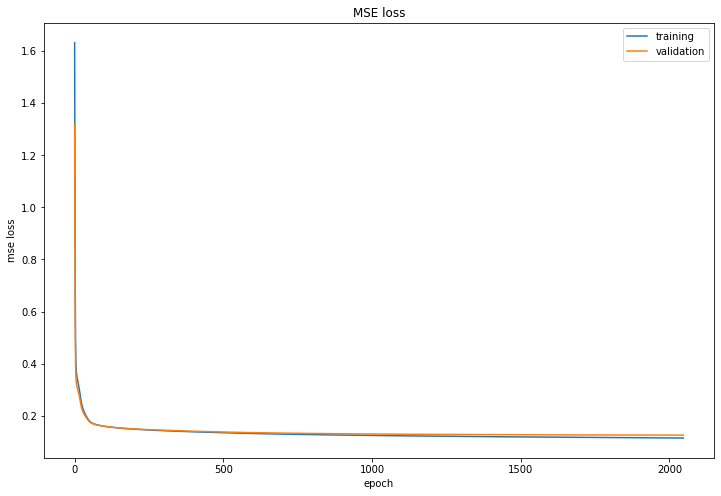

In [45]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [46]:
predictions = model.predict(test_input)

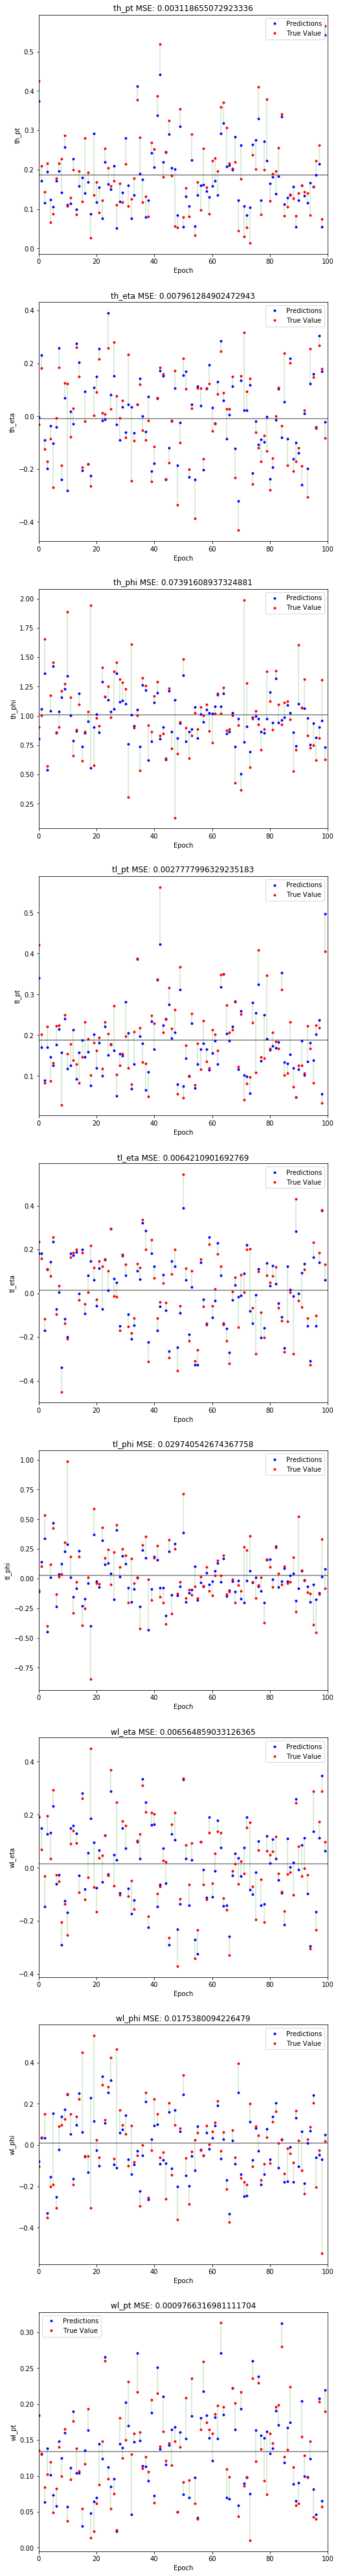

In [47]:

# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [48]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.025090347370517734
th_pt MSE :  0.0035445254
th_eta MSE :  0.0107646566
th_phi MSE :  0.1039483725
tl_pt MSE :  0.0028120718
tl_eta MSE :  0.0082144980
tl_phi MSE :  0.0663194401
wl_eta MSE :  0.0054712895
wl_phi MSE :  0.0234547881
wl_pt MSE :  0.0012834844


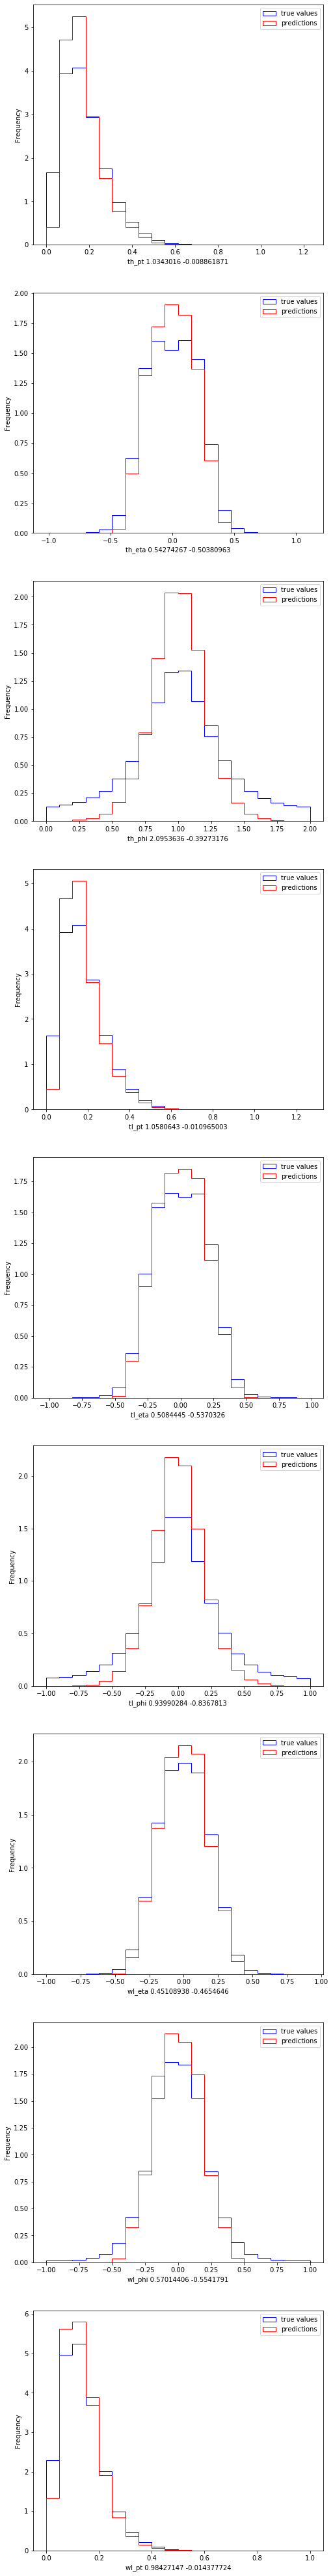

In [49]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [50]:
total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)[split:,:]

total_predictions = model.predict(total_input)
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean)[split:,:]


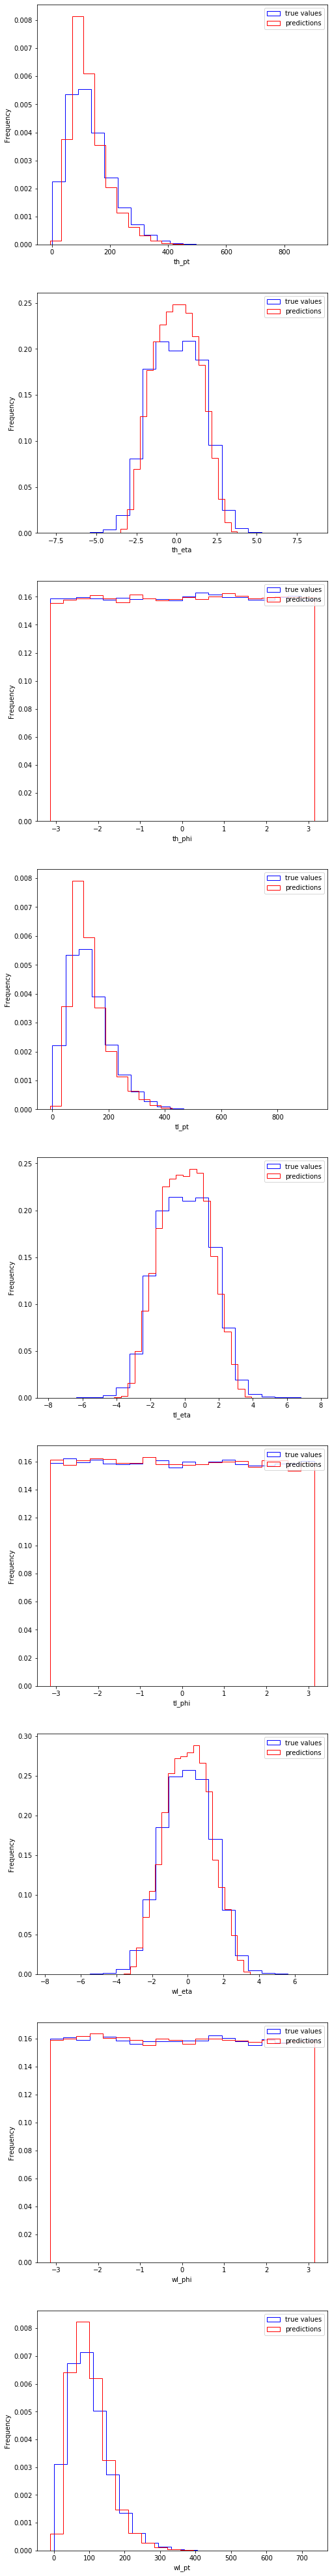

In [51]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [52]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  1914.8342267736
Original Scale th_eta MSE :  0.6410087524
Original Scale th_phi MSE :  0.9390819690
Original Scale tl_pt MSE :  1519.1459147802
Original Scale tl_eta MSE :  0.4891530942
Original Scale tl_phi MSE :  0.6092800953
Original Scale wl_eta MSE :  0.3258017989
Original Scale wl_phi MSE :  0.2217630370
Original Scale wl_pt MSE :  693.3678115621


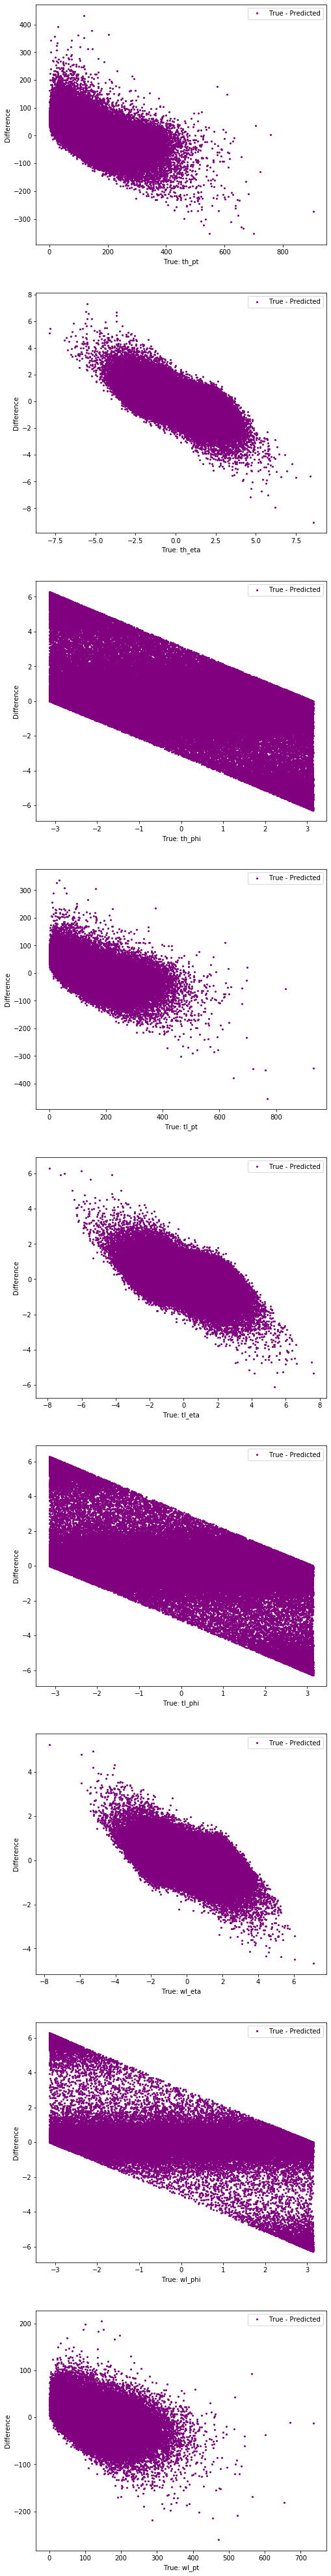

In [53]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')